# Example of Generator Placement

This is an example of how to use different strategies with **FORWARD** in order to solve generator placement problem.

First, intiallize the environment with all the needed packages and build functions.

In [1]:
include("../forward/Forward.jl")
include("../forward/Auxiliary.jl")
include("../data/GraphInit.jl")
include("../local_search/ConditionedGreedy.jl")
include("../local_search/ConditionedMarkovChain.jl")
using .Forward
using .Auxiliary
using .GraphInit
using .ConditionedGreedy
using .ConditionedMarkovChain
using Graphs
using MetaGraphs
using GraphPlot
using Plots
using JuMP
using Ipopt
using Combinatorics
using PowerModelsDistribution
const _PMD = PowerModelsDistribution
using GraphRecipes, Plots
using BenchmarkTools

Second, make usage of **GraphInit** to import a graph dataset. In this case, import a *.dss* file to create a DC power grid.

[ PowerModelsDistribution | Info ] : Circuit has been reset with the 'clear' on line 1 in 'ieee18.dss'
[ PowerModelsDistribution | Info ] : Command 'calcvoltagebases' on line 80 in 'ieee18.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'solve' on line 82 in 'ieee18.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : basemva=100 is the default value, you may want to adjust sbase_default for better convergence


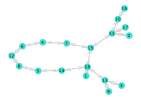

In [2]:
G,lookup_dict = GraphInit.dc_graph_initialization("../data/datasets/ieee18/ieee18.dss")
set_prop!(G,12,:p,2500)
id_list = [get_prop(G, i, :id) for i in 1:nv(G)]
gplot(G, nodelabel=id_list)

Using **Auxiliary** tools to check graph properties.

In [3]:
Auxiliary.show_node(G,:p)

Node 1 has p: -100.0
Node 2 has p: -400.0
Node 3 has p: -128.0
Node 4 has p: -150.0
Node 5 has p: -10.0
Node 6 has p: -500.0
Node 7 has p: -100.0
Node 8 has p: -200.0
Node 9 has p: -150.0
Node 10 has p: -170.0
Node 11 has p: -150.0
Node 12 has p: 2500
Node 13 has p: -100.0
Node 14 has p: -170.0
Node 15 has p: -200.0
Node 16 has p: -230.0
Node 17 has p: 2500.0
Node 18 has p: 2500.0


Let us **ConditionedGreedy** to decide which is the best combination of *k=2* sources. 

In [4]:
outlev = 0
V_g, S, f_S, termination_status = ConditionedGreedy.greedy(G, [17,18,12], 2, Ipopt.Optimizer,"greedy_max",outlev)






































******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************











































































































































([17, 12], {18, 17} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), 7.7551622211022355, 1)

We can plot the final radial distribution ploytree.

The cost is 7.7551622211022355 with the generators in [17, 12]


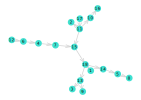

In [5]:
println("The cost is ",f_S," with the generators in ",V_g)
id_list = [get_prop(S, i, :id) for i in 1:nv(S)]
gplot(S, nodelabel=id_list)

Let us **Markov Chain** to decide which is the best combination of *k=2* sources.

In [6]:
limit_iters = 10; outlev = 0
V_g, S, f_S, termination_status = ConditionedMarkovChain.random_walk(G, [17,18,12], 2, Ipopt.Optimizer,"greedy_max",limit_iters,outlev)

([17, 12], {18, 17} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), 7.7551622211022355, 1)

We can plot the final radial distribution ploytree.

The cost is 7.7551622211022355 with the generators in [17, 12]


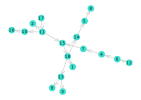

In [7]:
println("The cost is ",f_S," with the generators in ",V_g)
id_list = [get_prop(S, i, :id) for i in 1:nv(S)]
gplot(S, nodelabel=id_list)

Let us use **Benchmark** package to compare execution time and memory for both problems.  

In [8]:
@benchmark ConditionedGreedy.greedy(G, [17,18,12], 2, Ipopt.Optimizer,"greedy_max",outlev)

BenchmarkTools.Trial: 304 samples with 1 evaluation.
 Range (min … max):  13.757 ms … 174.386 ms  ┊ GC (min … max): 0.00% … 81.39%
 Time  (median):     15.190 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.436 ms ±   9.330 ms  ┊ GC (mean ± σ):  4.45% ±  5.70%

    ▁   ▁▅█▅▁                                                   
  ▅▇█▇▅▇██████▇▇▅▅█▂▄▃▃▃▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▃▃▄▃▃▃▂▃▃▁▂▂▃▂▂▃▁▂▂▁▁▁▃ ▃
  13.8 ms         Histogram: frequency by time         22.8 ms <

 Memory estimate: 6.77 MiB, allocs estimate: 82967.

In [9]:
@benchmark ConditionedMarkovChain.random_walk(G, [17,18,12], 2, Ipopt.Optimizer,"greedy_max",limit_iters,outlev)

BenchmarkTools.Trial: 508 samples with 1 evaluation.
 Range (min … max):  7.892 ms … 154.918 ms  ┊ GC (min … max): 0.00% … 84.37%
 Time  (median):     9.066 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.841 ms ±   6.636 ms  ┊ GC (mean ± σ):  4.19% ±  5.25%

    ▁▄▁▂██▄▄▁   ▁▁▂                                            
  ▄▆███████████▆███▅▇▆▅▅▄▄▃▂▃▂▃▁▂▁▁▂▁▁▁▁▁▁▁▂▃▁▂▃▂▂▂▁▁▂▃▃▃▃▃▃▄ ▄
  7.89 ms         Histogram: frequency by time        14.9 ms <

 Memory estimate: 4.10 MiB, allocs estimate: 50314.